In [1]:
import numpy as np
import pandas as pd
import theano 
from theano import tensor as T
from theano.tensor.nnet import conv2d
import sklearn

Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)
/home/james/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
class Convolution_Layer(object):
    
    def __init__(self, input, n_out, n_in, filter_size, batch_size, im_h,
                 im_w, W=None, b=None, stride=(1,1), padding='valid'):
        '''Convolution Layer for a CNN:
            
            input: Theano.tensor.dtensor4 representing a 4d-tensor of minibatches:
                   I[batch_size, n_in, image height, image width].
                   im_h = image height
                   im_w = image width
                       
            n_out: The number of feature maps to output. I.e the number of filters.
            
            n_in: The number of input feature maps.
            
            filter_size: A list [n,m] representing the dimension of receptive field.
                         E.g. filter_size = (3,2) corresponds to a 3x2 receptive field.
                    
            W and b: The weight and bias tensors for the layer. Leave the default to
                     generate a random initial to be tuned by training, or input 
                     pre-trained weights to fine tune.
                     
            stride: The stride, note this may mess with GPU acceleration so may actually
                    slow training if set beyond default.
            
            padding:  Any of the following:
                        "valid": Apply filter wherever it completely overlaps with the
                                input. Generates output of shape: input shape - filter shape + 1
                                
                        "full": Apply filter wherever it partly overlaps with the input.
                                Generates output of shape: input shape + filter shape - 1
                                
                        "half": Pad input with a symmetric border of "filter rows // 2"
                                rows and "filter columns // 2" columns, then perform a valid
                                convolution. For filters with an odd number of rows and columns, this
                                leads to the output shape being equal to the input shape.
                                
                        "int": Pad input with a symmetric border of zeros of the given
                               width, then perform a valid convolution.
                                 
                        "(int1, int2)": Pad input with a symmetric border of "int1" rows
                                        and "int2" columns, then perform a valid convolution.
                                    
            output: A 4d-tensor containing the n_out feature maps and in a batch. 
                    Note: the image dimensions are altered by filter of size [n,m]: 
                          im_h_out = im_h + 1 - n
                          im_w_out = im_w + 1 - m

                        '''
        
        if W == None:
            
            filt_shp = [n_out, n_in, filter_size[0], filter_size[1]]
            fan_in = n_in * filt_shp[0] * filt_shp[1]
            fan_out = n_out * filt_shp[0] * filt_shp[1]
            r = np.sqrt(6 / (fan_in + fan_out))
            W = np.random.uniform(low=-r, high=r, size=filt_shp)
            
                
        if b == None:
            
            b = np.zeros((n_out,), dtype=theano.config.floatX)
        
        self.input = input
        self.W = theano.shared(value=np.asarray(W, dtype=theano.config.floatX), borrow=True)
        self.b = theano.shared(value=b, borrow=True)
        self.params = [self.W, self.b]
        
       
            
        output = (conv2d(input=self.input, filters=self.W,
                        input_shape=[batch_size, n_in, im_h, im_w],
                        filter_shape=[n_out, n_in] + filter_size,
                        border_mode=padding, subsample=stride) + 
                  self.b.dimshuffle('x',0,'x','x'))
            
        self.output = output

In [3]:
class Max_Pool_Layer(object):
    
    def __init__(self, input, max_pool_shp=(2,2)):
        '''Max-Pool Subsample Layer for a CNN
          
          input: A 4d-tensor I[batch_size, feature_maps, im_h, im_w]. 
        
          max_pool_shape: An array (n,m) representing patch dimensions to pool over. 
                          Default = (2,2).
          
          output: Maxpooled subsample. 
                  Note: Image dimension are divided by pool shape (n,m).
                        im_h_out = [im_h / n]   ([x] is the floor function)
                        im_w_out = [im_w / m]
        '''
        
        self.output = T.signal.pool.pool_2d(input, max_pool_shp, ignore_border=1)

In [4]:
class ReLu_Layer(object):
    
    def __init__(self, input, leak=0):
        '''Rectified  Linear Unit Activation Layer for a NN
        
        input: An n-dimensional array or tensor.
        
        leak: A float in interval [0,1] which gives the slope for negative 
              input. Leak is zero by default and corresponds to 
              ReLu(x) = max(0,x). Leak = 1 corresponds to ReLu(x) = x. 
              Any value m inbetween gives: 
              ReLu(x) = (m * x * I(x < 0)) + (x * I(x >= 0))
              
        output: Elementwise ReLu(x) 
        '''
       
        
        self.input = input
        self.output = T.nnet.relu(self.input,alpha=leak)

In [5]:
class Sigmoid_Layer(object):
    
    def __init__(self, input):
        '''Logisitic Sigmoid Activation Layer for a NN
        
        input: An n-dimensional array or tensor
        
        output: Elementwise sigmoid(x), implemented in a 
                (hopefully) numerically stable way.
        
        '''
        
        self.input = input
        self.output = T.exp(-T.log(1+T.exp(-self.input / 10)))

In [6]:
class FC_Layer(object):
    
    def __init__(self,input, n_in, n_out, W=None, b=None):
        '''Fully Connected Neural Layer for a NN
        
        input: A 2d-array or tensor.
        
        n_in and n_out: Number of input and output (resp.) neurons. 
        
        W and b: Optional pre-trained weights.
        
        output: Matrix corresponding to Wx_i + b
        
        '''
        
        self.input = input
    
        if W == None:
            
            r = np.sqrt(6 / (n_in + n_out))
            W = np.random.uniform(low=-r, high=r, size=(n_in,n_out))

                
        if b == None:
            
            b = np.zeros((n_out,), dtype=theano.config.floatX)
            
        
        self.W = theano.shared(value=np.asarray(W,dtype=theano.config.floatX), borrow=True)
        self.b = theano.shared(value=b, borrow=True)
        self.params = [self.W, self.b]
        self.output = T.dot(input, self.W) + self.b

In [7]:
class Softmax_Layer(object):
    
    def __init__(self, input, batch_size, n_in, n_out, W=None, b=None):
        '''Softmax Activation Layer for a NN
        
        input: A 2d-array or tensor.
        
        batch_size: Batch size to be used in model.
        
        n_in and n_out: Number of input neurons and outputs neurons. Most
                        likely this is final layer so n_ou should be the
                        number of possible classes.
                        
        W, b: Pre-trained weights if so desired. 
        
        output: The log-softmax probability of each class.
        
        '''
        
        self.input = input
        self.bs = batch_size
        self.num_class = n_out
            
        
        if W == None:
            
            r = np.sqrt(6 / (n_in + n_out))
            W = np.random.uniform(low=-r, high=r, size=(n_in,n_out))

                
        if b == None:
            
            b = np.zeros((n_out,), dtype=theano.config.floatX)
            
        self.W = theano.shared(value=np.asarray(W,dtype=theano.config.floatX), borrow=True)
        self.b = theano.shared(value=b, borrow=True)
        self.params = [self.W, self.b]
        trans = T.dot(input, self.W) + self.b
        
        # Using a numerically stable log-softmax implementation.
        
        dx = trans - trans.max(1,keepdims=1)
        self.output = dx - T.log(T.sum(T.exp(dx),axis=1,keepdims=1))
        
        
        self.prediction = T.argmax(self.output, axis=1)
           
        
    def cross_entropy_loss(self, y):      
        
        return -T.sum(y*self.output, axis=1)
    
    def percent_score(self, y):
        
        a = self.prediction
        b = T.argmax(y, axis=1)
        
        out = 1 - (T.neq(a,b).sum() / self.bs)
        
        return out
        

In [8]:
#Building a CNN to classify MNIST images

class ConvNet(object):
    
    def __init__(self, input, batch_size):
        
        self.input = input.reshape((batch_size, 1, 28, 28)) / 255
       
        self.layer_1 = Convolution_Layer(input=self.input, n_out=50, n_in=1,
                                         filter_size=[5,5], batch_size=batch_size, 
                                         im_h=28, im_w=28)
        
        self.layer_2 = ReLu_Layer(input=self.layer_1.output)
        
        self.layer_3 = Max_Pool_Layer(input=self.layer_2.output)
        
        self.layer_4 = Convolution_Layer(input=self.layer_3.output, n_out=50, n_in=50,
                                        filter_size=[3,3], batch_size=batch_size,
                                        im_h=12, im_w=12)
        
        self.layer_5 = ReLu_Layer(input=self.layer_4.output)
        
        self.layer_5_prime = Max_Pool_Layer(input=self.layer_5.output)
        
        self.layer_6 = FC_Layer(input=T.flatten(x=self.layer_5_prime.output,outdim=2),
                                n_in=50*25, n_out=batch_size)
        
        self.layer_7 = ReLu_Layer(input=self.layer_6.output)
        
        self.layer_8 = Softmax_Layer(self.layer_7.output, batch_size=batch_size, n_in=batch_size,
                                    n_out=10)
        
        self.params = self.layer_8.params + self.layer_6.params + self.layer_4.params + self.layer_1.params
        
    def cost(self, y):
            
        return self.layer_8.cross_entropy_loss(y)
        
    def percent_score(self, y):
            
        return self.layer_8.percent_score(y)                       

In [9]:
#Initialize the model as a computational graph.

x = T.fmatrix('x')
y = T.fmatrix('y')

clf = ConvNet(input=x, batch_size=256)

In [10]:
#Prepare the data for the model
#MNIST data is taken from the kaggle digit recognizer competition

data_df = pd.read_csv('/home/james/anaconda3/data/mnist.csv')

data = data_df.as_matrix()

In [11]:
np.random.shuffle(data)

In [12]:
data_X = np.asarray(data[:,1:], dtype='float32')
data_Y = np.asarray(data[:,0], dtype='float32')

In [13]:
data_Y_dum = pd.get_dummies(data_Y)
data_Y_m = data_Y_dum.as_matrix()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold = train_test_split(data_X, data_Y_m, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5)

In [15]:
X_train_T = theano.shared(value=X_train, borrow=True)
y_train_T = theano.shared(value=np.asarray(y_train, dtype='float32'), borrow=1)
X_test_T = theano.shared(value=X_test, borrow=1)
y_test_T = theano.shared(value=np.asarray(y_test, dtype='float32'), borrow=1)
X_val_T = theano.shared(value=X_valid, borrow=1)
y_val_T = theano.shared(value=np.asarray(y_valid, dtype='float32'), borrow=1)

In [17]:
#Prep the model for training

index = T.lscalar('index')
BS = 256                        # Batch Size

cost = T.mean(clf.cost(y))
model_validate = theano.function(inputs=[index], outputs=clf.percent_score(y),
                                givens={x:X_val_T[index * BS : (index + 1) * BS],
                                        y:y_val_T[index * BS : (index + 1) * BS]},
                                allow_input_downcast=1)

model_test = theano.function(inputs=[index], outputs=clf.percent_score(y),
                            givens={x:X_test_T[index * BS : (index + 1) * BS],
                                    y:y_test_T[index * BS : (index + 1) * BS]},
                            allow_input_downcast=1)
updates = []
momentum = 0.9
l_r = 0.01

for p in clf.params:
    
    moment = theano.shared(p.get_value() *0 , broadcastable=p.broadcastable)
    moment_up = (momentum * moment) - (l_r * theano.gradient.grad(cost,p))
    updates.append((moment, moment_up))
    updates.append((p, p + moment_up))


#grads = [theano.gradient.grad(cost,param) for param in clf.params]
#updates = [(p,p - 0.01 * g) for p,g in zip(clf.params,grads)]   


model_train = theano.function(inputs=[index], outputs=cost,
                             givens={x:X_train_T[index * BS : (index + 1) * BS],
                                     y:y_train_T[index * BS : (index + 1) * BS]},
                             updates=updates, allow_input_downcast=1)


#ADAM for use later

updates = []
l = 0.001
B1 = 0.9
B2 = 0.999
ep = 1e-8
t = theano.shared(np.float32(0.0))
t_up = t + 1

for p, g in zip(clf.params, grads):
    
    m = theano.shared(p.get_value() * 0)
    v = theano.shared(p.get_value() * 0)
    m_up = (B1*m + (1-B1)*g) / (1-(B1**t_up))
    v_up = (B2*v + (1-B2)*T.sqr(g)) / (1-(B2**t_up))
    p_up = p - (l * m_up) / (T.sqrt(v_up) + ep)
    updates.append((m, m_up))
    updates.append((v, v_up))
    updates.append((p, p_up))

updates.append((t, t_up))

In [18]:
#Train the model
import timeit

print('Training')

patience = 10000
patience_inc = 2
improvement_thresh = 0.995
epoch = 0
epoch_size = X_train.shape[0] // BS
valid_size = X_val_T.get_value().shape[0] // BS
test_size = X_test_T.get_value().shape[0] // BS
valid_freq = min(epoch_size, patience // 2)
best_valid_score = 0
best_iter = 0
test_score = 0

stop_early = False
start_time = timeit.default_timer()

while (epoch <= 5000) and (not stop_early):
    
    epoch += 1
    
    for k in range(epoch_size):
        
        mini_batch_cost = model_train(k)
        iter = ((epoch - 1) * 1000) + k
        
        if (iter + 1) % valid_freq == 0:
            
            valid_losses = [model_validate(valid_index) for valid_index in range(valid_size)]
            avg_loss = np.mean(valid_losses)
            
            print('Epoch number : ', epoch, '. Validation correct : ', avg_loss * 100, '%')
            
            if avg_loss > best_valid_score: 
                
                if avg_loss > best_valid_score * improvement_thresh:
                    
                    patience = max(patience, iter * patience_inc)
                    
                best_valid_score = avg_loss
                best_iter = iter
            
            test_losses = [model_test(test_index) for test_index in range(test_size)]
            test_score = np.mean(test_losses)
                
                
        
            
            
        if patience <= iter:
            early_stop = True
            break
            
end_time = timeit.default_timer()

print('The model has been fit. Best validation percentage : ', best_valid_score * 100, '% obtained at iteration : ',
      best_iter, ' current test percentage : ', test_score * 100, '%. Training ran for ', epoch, ' epochs',
     ' and took ', round((end_time - start_time) / 60,2), ' min to converge.')

Training
Epoch number :  1 . Validation correct :  89.5751953125 %
Epoch number :  2 . Validation correct :  92.919921875 %
Epoch number :  3 . Validation correct :  95.7763671875 %
Epoch number :  4 . Validation correct :  96.38671875 %
Epoch number :  5 . Validation correct :  97.0947265625 %
Epoch number :  6 . Validation correct :  97.1435546875 %
Epoch number :  7 . Validation correct :  97.1923828125 %
Epoch number :  8 . Validation correct :  97.265625 %
Epoch number :  9 . Validation correct :  97.8271484375 %
Epoch number :  10 . Validation correct :  97.8759765625 %
Epoch number :  11 . Validation correct :  97.0703125 %
Epoch number :  12 . Validation correct :  97.9248046875 %
Epoch number :  13 . Validation correct :  98.1689453125 %
Epoch number :  14 . Validation correct :  97.900390625 %
Epoch number :  15 . Validation correct :  98.33984375 %
Epoch number :  16 . Validation correct :  98.4375 %
Epoch number :  17 . Validation correct :  98.046875 %
Epoch number :  18 .

Above training was run multiple times. 

In [58]:
def model_predict(low, up, data, batch_size=256):
    '''k = index of element we want to predict '''
    i, k = T.lscalar(), T.lscalar()
    assert (up - low) == batch_size  
    data_T = theano.shared(np.asarray(data,dtype='float32'), borrow=1)
    pred = theano.function([i,k], clf.layer_8.prediction, 
                           givens={x:data_T[i : k]})
    
    return pred(low, up)

In [22]:
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

Predicted number :  6


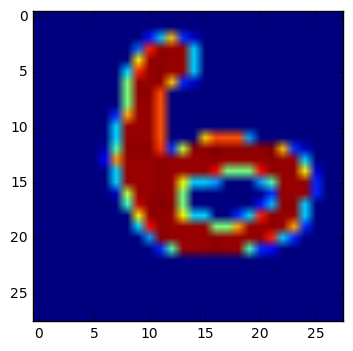

In [54]:
first_256_pred = model_predict(0, 256, data_X)
print('Predicted number : ', first_256_pred[0])
plt.imshow(data_X[0].reshape((28,28)))

In [48]:
mnist_test = (pd.read_csv('/home/james/anaconda3/data/mnistT.csv')).as_matrix()
mnist_test.shape

(28000, 784)

In [62]:
print(28000 // 256)
print(109 * 256)
print(27904 + 256)

109
27904
28160


In [64]:
results = np.asarray(np.zeros(28000),dtype='int32')

for k in range(0,27904,256):
    
    preds = model_predict(k, k+256, mnist_test)
    
    for j in range(k,k+256):
        
        results[j] = preds[j % 256]
        
last_preds = model_predict(28000-256, 28000, mnist_test)

for k in range(28000-256, 28000):
    
    results[k] = last_preds[(k+160) % 256]

In [70]:
results_df = pd.DataFrame(data=pd.Series(data=np.arange(1,28001)), columns=['ImageId'])

In [72]:
results_df['Label'] = pd.Series(results)

In [73]:
results_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [74]:
results_df.to_csv('/home/james/anaconda3/data/mnistR.csv',index=0)

These results got 98.829% accuracy on the test set of 28000 images for the competition.
Currently this places me at 361 / 1439, or top 26%
https://www.kaggle.com/c/digit-recognizer/leaderboard